# Решение задачи классификации, болен ли пациент, при помощи градиентного бустинга.

Датасет `dataset/heart_disease_uci.csv`. Таргет (`0 < num`) - болен ли пациент (стадия болезни не меньше 1). 

In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, RandomizedSearchCV
from sklearn.ensemble import GradientBoostingClassifier, HistGradientBoostingClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, classification_report, roc_curve
from sklearn.preprocessing import OneHotEncoder, StandardScaler, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.feature_selection import SelectFromModel, RFE
from sklearn.model_selection import StratifiedKFold
from sklearn.linear_model import LogisticRegression
import warnings
warnings.filterwarnings('ignore')

heart_df = pd.read_csv('dataset/heart_disease_uci.csv')

heart_df['target'] = (heart_df['num'] > 0).astype(int)
heart_df = heart_df.drop(['id', 'dataset', 'num'], axis=1)

### Учитывая, что тот же датасет использовался в предыдущих работах, пропустим этам с анализом данных.

In [9]:
X_class = heart_df.drop(['target'], axis=1)
y_class = heart_df['target']

categorical_features = ['sex', 'cp', 'fbs', 'restecg', 'exang', 'slope', 'thal']
numeric_features = [col for col in X_class.columns if col not in categorical_features]

### Создадим бейзлайн

In [10]:
X_train_c, X_test_c, y_train_c, y_test_c = train_test_split(
    X_class, y_class, test_size=0.2, random_state=42, stratify=y_class
)

print(f"Размер тренировочной выборки: {X_train_c.shape}")
print(f"Размер тестовой выборки: {X_test_c.shape}")

preprocessor = ColumnTransformer(
    transformers=[
        ('num', SimpleImputer(strategy='mean'), numeric_features),
        ('cat', OneHotEncoder(handle_unknown='ignore', sparse_output=False), categorical_features)
    ])

gbc = GradientBoostingClassifier(random_state=42)
gb_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', gbc)
])

gb_pipeline.fit(X_train_c, y_train_c)

Размер тренировочной выборки: (736, 13)
Размер тестовой выборки: (184, 13)


,steps,"[('preprocessor', ...), ('classifier', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('num', ...), ('cat', ...)]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


### Оценим его


Качество бейзлайн модели (Gradient Boosting):
Accuracy: 0.8424
Precision: 0.8476
Recall: 0.8725
F1 Score: 0.8599
ROC-AUC: 0.9073


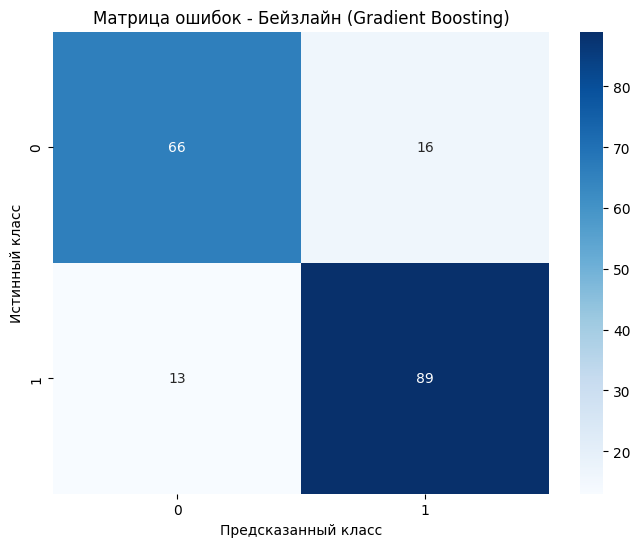

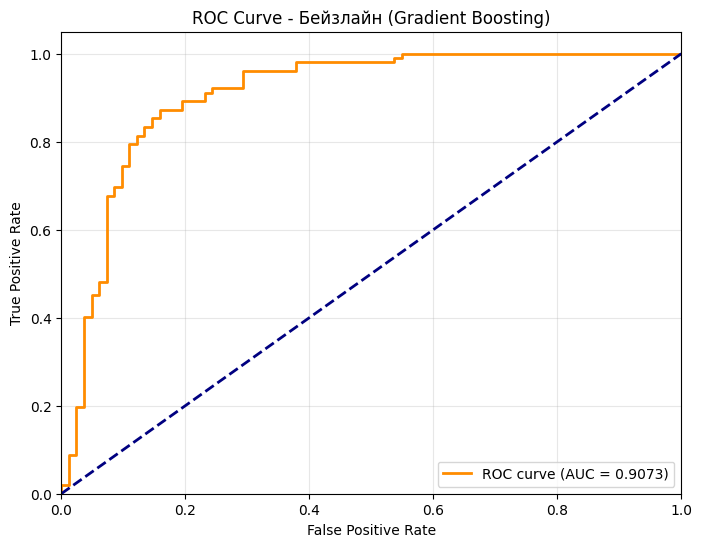


Отчет о классификации:
              precision    recall  f1-score   support

           0       0.84      0.80      0.82        82
           1       0.85      0.87      0.86       102

    accuracy                           0.84       184
   macro avg       0.84      0.84      0.84       184
weighted avg       0.84      0.84      0.84       184



In [11]:
y_pred_c = gb_pipeline.predict(X_test_c)
y_pred_proba_c = gb_pipeline.predict_proba(X_test_c)[:, 1]

print("\nКачество бейзлайн модели (Gradient Boosting):")
print("="*40)
print(f"Accuracy: {accuracy_score(y_test_c, y_pred_c):.4f}")
print(f"Precision: {precision_score(y_test_c, y_pred_c):.4f}")
print(f"Recall: {recall_score(y_test_c, y_pred_c):.4f}")
print(f"F1 Score: {f1_score(y_test_c, y_pred_c):.4f}")
print(f"ROC-AUC: {roc_auc_score(y_test_c, y_pred_proba_c):.4f}")

conf_matrix = confusion_matrix(y_test_c, y_pred_c)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.title('Матрица ошибок - Бейзлайн (Gradient Boosting)')
plt.ylabel('Истинный класс')
plt.xlabel('Предсказанный класс')
plt.show()

fpr, tpr, thresholds = roc_curve(y_test_c, y_pred_proba_c)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc_score(y_test_c, y_pred_proba_c):.4f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Бейзлайн (Gradient Boosting)')
plt.legend(loc="lower right")
plt.grid(alpha=0.3)
plt.show()

print("\nОтчет о классификации:")
print(classification_report(y_test_c, y_pred_c))

### Исследуем влияние признаков

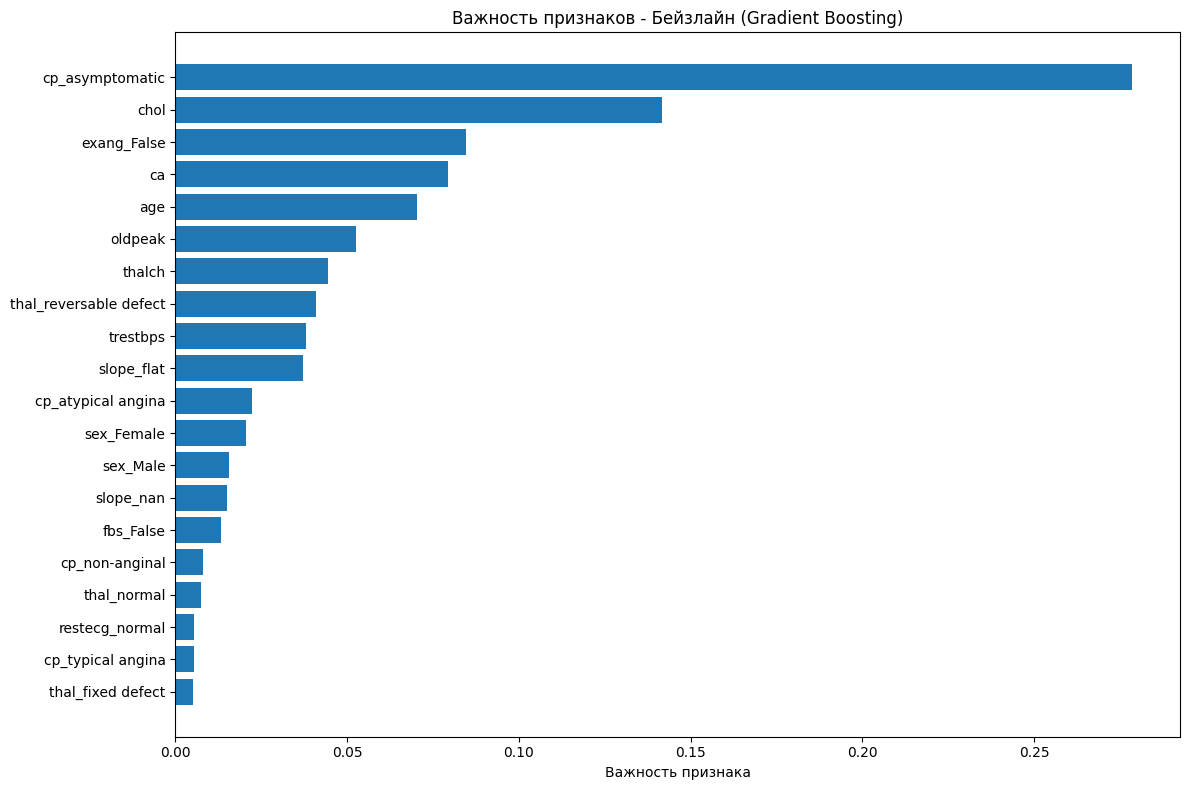

In [12]:
gb_model = gb_pipeline.named_steps['classifier']
preprocessor.fit(X_train_c)

feature_names = []
for name, transformer, features in preprocessor.transformers_:
    if name == 'cat':
        encoder = transformer
        cat_features = encoder.get_feature_names_out(features)
        feature_names.extend(cat_features)
    else:
        feature_names.extend(features)

importances = gb_model.feature_importances_
indices = np.argsort(importances)[::-1]

plt.figure(figsize=(12, 8))
plt.title('Важность признаков - Бейзлайн (Gradient Boosting)')
plt.barh(range(min(20, len(feature_names))), importances[indices][:20][::-1])
plt.yticks(range(min(20, len(feature_names))), [feature_names[i] for i in indices[:20][::-1]])
plt.xlabel('Важность признака')
plt.tight_layout()
plt.show()

### Попробуем улучшить бейзлайн
Гипотезы
1. Использование более сложной стратегии импутации (KNN)
2. Стандартизация числовых признаков (важно для градиентного бустинга)
3. Подбор гиперпараметров с фокусом на параметры бустинга
4. Использование HistGradientBoosting для скорости
5. Балансировка классов (class_weight или sample_weight)
6. Изменение скорости обучения и количества деревьев
7. Ранняя остановка (early stopping)

In [13]:
print("\nГипотеза 1: Использование KNNImputer вместо SimpleImputer")

preprocessor_knn = ColumnTransformer(
    transformers=[
        ('num', KNNImputer(n_neighbors=5), numeric_features),
        ('cat', OneHotEncoder(handle_unknown='ignore', sparse_output=False), categorical_features)
    ])

gb_pipeline_knn = Pipeline(steps=[
    ('preprocessor', preprocessor_knn),
    ('classifier', GradientBoostingClassifier(random_state=42))
])

gb_pipeline_knn.fit(X_train_c, y_train_c)
y_pred_knn = gb_pipeline_knn.predict(X_test_c)

print(f"Accuracy с KNNImputer: {accuracy_score(y_test_c, y_pred_knn):.4f}")
print(f"F1 Score с KNNImputer: {f1_score(y_test_c, y_pred_knn):.4f}")


Гипотеза 1: Использование KNNImputer вместо SimpleImputer
Accuracy с KNNImputer: 0.8587
F1 Score с KNNImputer: 0.8750


In [14]:
print("\nГипотеза 2: Стандартизация числовых признаков")

preprocessor_std = ColumnTransformer(
    transformers=[
        ('num', Pipeline([
            ('imputer', SimpleImputer(strategy='mean')),
            ('scaler', StandardScaler())
        ]), numeric_features),
        ('cat', OneHotEncoder(handle_unknown='ignore', sparse_output=False), categorical_features)
    ])

gb_pipeline_std = Pipeline(steps=[
    ('preprocessor', preprocessor_std),
    ('classifier', GradientBoostingClassifier(random_state=42))
])

gb_pipeline_std.fit(X_train_c, y_train_c)
y_pred_std = gb_pipeline_std.predict(X_test_c)

print(f"Accuracy со стандартизацией: {accuracy_score(y_test_c, y_pred_std):.4f}")
print(f"F1 Score со стандартизацией: {f1_score(y_test_c, y_pred_std):.4f}")


Гипотеза 2: Стандартизация числовых признаков
Accuracy со стандартизацией: 0.8424
F1 Score со стандартизацией: 0.8599


In [15]:
print("\nГипотеза 3: Подбор гиперпараметров с RandomizedSearchCV")

param_grid_gb = {
    'classifier__n_estimators': [100, 200, 300],
    'classifier__learning_rate': [0.01, 0.05, 0.1, 0.2],
    'classifier__max_depth': [3, 4, 5, 6],
    'classifier__min_samples_split': [2, 5, 10],
    'classifier__min_samples_leaf': [1, 2, 4],
    'classifier__subsample': [0.8, 0.9, 1.0],
    'classifier__max_features': ['sqrt', 'log2', None]
}

base_gb_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', GradientBoostingClassifier(random_state=42))
])

gb_random_search = RandomizedSearchCV(
    base_gb_pipeline,
    param_distributions=param_grid_gb,
    n_iter=30,
    cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=42),
    scoring='f1',
    n_jobs=-1,
    random_state=42,
    verbose=1
)

print("Начинаем подбор гиперпараметров для Gradient Boosting...")
gb_random_search.fit(X_train_c, y_train_c)

print(f"\nЛучшие параметры: {gb_random_search.best_params_}")
print(f"Лучший F1 Score на кросс-валидации: {gb_random_search.best_score_:.4f}")

y_pred_tuned = gb_random_search.predict(X_test_c)
y_pred_proba_tuned = gb_random_search.predict_proba(X_test_c)[:, 1]

print(f"\nКачество на тестовой выборке после подбора гиперпараметров:")
print(f"Accuracy: {accuracy_score(y_test_c, y_pred_tuned):.4f}")
print(f"Precision: {precision_score(y_test_c, y_pred_tuned):.4f}")
print(f"Recall: {recall_score(y_test_c, y_pred_tuned):.4f}")
print(f"F1 Score: {f1_score(y_test_c, y_pred_tuned):.4f}")
print(f"ROC-AUC: {roc_auc_score(y_test_c, y_pred_proba_tuned):.4f}")


Гипотеза 3: Подбор гиперпараметров с RandomizedSearchCV
Начинаем подбор гиперпараметров для Gradient Boosting...
Fitting 5 folds for each of 30 candidates, totalling 150 fits

Лучшие параметры: {'classifier__subsample': 1.0, 'classifier__n_estimators': 200, 'classifier__min_samples_split': 10, 'classifier__min_samples_leaf': 2, 'classifier__max_features': 'log2', 'classifier__max_depth': 6, 'classifier__learning_rate': 0.01}
Лучший F1 Score на кросс-валидации: 0.8455

Качество на тестовой выборке после подбора гиперпараметров:
Accuracy: 0.8587
Precision: 0.8519
Recall: 0.9020
F1 Score: 0.8762
ROC-AUC: 0.9279


In [16]:
print("\nГипотеза 5: Балансировка классов с sample_weight")

from sklearn.utils.class_weight import compute_sample_weight

sample_weights = compute_sample_weight('balanced', y_train_c)

gb_pipeline_balanced = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', GradientBoostingClassifier(random_state=42))
])

gb_pipeline_balanced.fit(X_train_c, y_train_c, classifier__sample_weight=sample_weights)
y_pred_balanced = gb_pipeline_balanced.predict(X_test_c)

print(f"Accuracy с балансировкой классов: {accuracy_score(y_test_c, y_pred_balanced):.4f}")
print(f"F1 Score с балансировкой классов: {f1_score(y_test_c, y_pred_balanced):.4f}")
print(f"Recall с балансировкой классов: {recall_score(y_test_c, y_pred_balanced):.4f}")

print("\nГипотеза 6: Ранняя остановка (early stopping)")

X_train_sub, X_val, y_train_sub, y_val = train_test_split(
    X_train_c, y_train_c, test_size=0.2, random_state=42, stratify=y_train_c
)

gb_early = GradientBoostingClassifier(
    n_estimators=1000,
    learning_rate=0.05,
    subsample=0.8,
    max_depth=4,
    random_state=42,
    validation_fraction=0.1,
    n_iter_no_change=20,
    tol=1e-4
)

gb_early_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', gb_early)
])

gb_early_pipeline.fit(X_train_c, y_train_c)
y_pred_early = gb_early_pipeline.predict(X_test_c)

print(f"Количество деревьев после ранней остановки: {gb_early.n_estimators_}")
print(f"Accuracy с ранней остановкой: {accuracy_score(y_test_c, y_pred_early):.4f}")
print(f"F1 Score с ранней остановкой: {f1_score(y_test_c, y_pred_early):.4f}")


Гипотеза 5: Балансировка классов с sample_weight
Accuracy с балансировкой классов: 0.8424
F1 Score с балансировкой классов: 0.8585
Recall с балансировкой классов: 0.8627

Гипотеза 6: Ранняя остановка (early stopping)
Количество деревьев после ранней остановки: 60
Accuracy с ранней остановкой: 0.8533
F1 Score с ранней остановкой: 0.8720


### Посмотрим на то, как себя покажет улучшенный бейзлайн


Качество улучшенной модели:
Accuracy: 0.8696
Precision: 0.8679
Recall: 0.9020
F1 Score: 0.8846
ROC-AUC: 0.9357
Количество деревьев после ранней остановки: 197


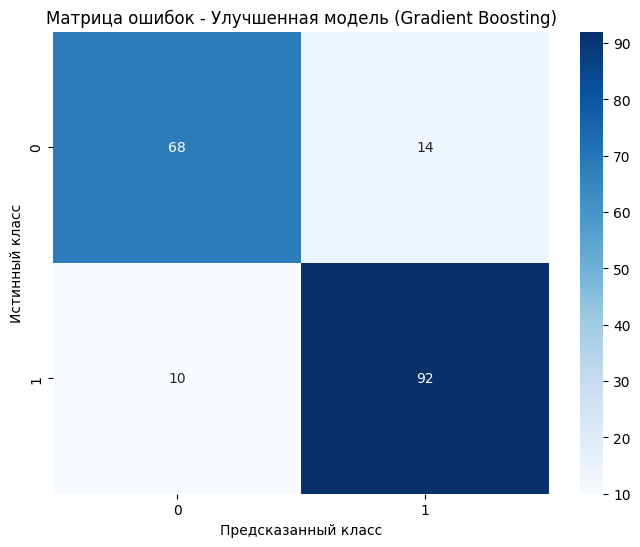

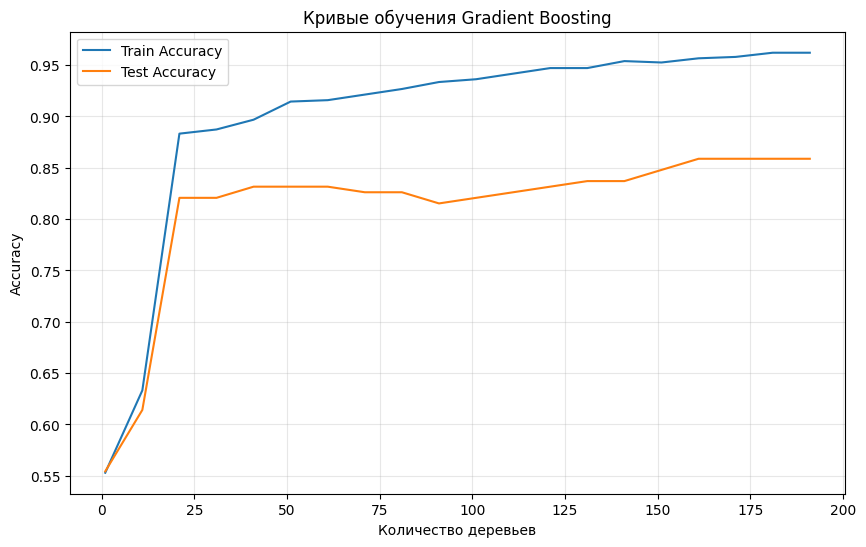

In [17]:
improved_preprocessor = ColumnTransformer(
    transformers=[
        ('num', Pipeline([
            ('imputer', KNNImputer(n_neighbors=5)),
            ('scaler', StandardScaler())
        ]), numeric_features),
        ('cat', OneHotEncoder(handle_unknown='ignore', sparse_output=False), categorical_features)
    ])

best_params = gb_random_search.best_params_

improved_gb = GradientBoostingClassifier(
    n_estimators=500,
    learning_rate=best_params.get('classifier__learning_rate', 0.1),
    max_depth=best_params.get('classifier__max_depth', 3),
    min_samples_split=best_params.get('classifier__min_samples_split', 2),
    min_samples_leaf=best_params.get('classifier__min_samples_leaf', 1),
    subsample=best_params.get('classifier__subsample', 1.0),
    max_features=best_params.get('classifier__max_features', None),
    validation_fraction=0.1,
    n_iter_no_change=20,
    tol=1e-4,
    random_state=42
)

improved_pipeline = Pipeline(steps=[
    ('preprocessor', improved_preprocessor),
    ('classifier', improved_gb)
])

sample_weights = compute_sample_weight('balanced', y_train_c)
improved_pipeline.fit(X_train_c, y_train_c, classifier__sample_weight=sample_weights)

y_pred_improved = improved_pipeline.predict(X_test_c)
y_pred_proba_improved = improved_pipeline.predict_proba(X_test_c)[:, 1]

print("\nКачество улучшенной модели:")
print(f"Accuracy: {accuracy_score(y_test_c, y_pred_improved):.4f}")
print(f"Precision: {precision_score(y_test_c, y_pred_improved):.4f}")
print(f"Recall: {recall_score(y_test_c, y_pred_improved):.4f}")
print(f"F1 Score: {f1_score(y_test_c, y_pred_improved):.4f}")
print(f"ROC-AUC: {roc_auc_score(y_test_c, y_pred_proba_improved):.4f}")
print(f"Количество деревьев после ранней остановки: {improved_gb.n_estimators_}")

conf_matrix_improved = confusion_matrix(y_test_c, y_pred_improved)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_improved, annot=True, fmt='d', cmap='Blues')
plt.title('Матрица ошибок - Улучшенная модель (Gradient Boosting)')
plt.ylabel('Истинный класс')
plt.xlabel('Предсказанный класс')
plt.show()

train_scores = []
test_scores = []
n_estimators_range = range(1, improved_gb.n_estimators_ + 1, 10)

for n_est in n_estimators_range:
    gb_temp = GradientBoostingClassifier(
        n_estimators=n_est,
        learning_rate=improved_gb.learning_rate,
        max_depth=improved_gb.max_depth,
        random_state=42
    )
    
    temp_pipeline = Pipeline(steps=[
        ('preprocessor', improved_preprocessor),
        ('classifier', gb_temp)
    ])
    
    temp_pipeline.fit(X_train_c, y_train_c)
    
    train_pred = temp_pipeline.predict(X_train_c)
    test_pred = temp_pipeline.predict(X_test_c)
    
    train_scores.append(accuracy_score(y_train_c, train_pred))
    test_scores.append(accuracy_score(y_test_c, test_pred))

plt.figure(figsize=(10, 6))
plt.plot(n_estimators_range, train_scores, label='Train Accuracy')
plt.plot(n_estimators_range, test_scores, label='Test Accuracy')
plt.xlabel('Количество деревьев')
plt.ylabel('Accuracy')
plt.title('Кривые обучения Gradient Boosting')
plt.legend()
plt.grid(alpha=0.3)
plt.show()

### Сравним результаты с бейзлайном


Сравнение моделей Gradient Boosting:
                Модель  Accuracy  Precision   Recall  F1 Score  ROC-AUC
              Бейзлайн  0.842391   0.847619 0.872549  0.859903 0.907341
           KNN Imputer  0.858696   0.858491 0.892157  0.875000 0.912123
        Стандартизация  0.842391   0.847619 0.872549  0.859903 0.907221
Подбор гиперпараметров  0.858696   0.851852 0.901961  0.876190 0.927905
  Балансировка классов  0.842391   0.854369 0.862745  0.858537 0.911526
      Ранняя остановка  0.853261   0.844037 0.901961  0.872038 0.915591
            Улучшенная  0.869565   0.867925 0.901961  0.884615 0.935677


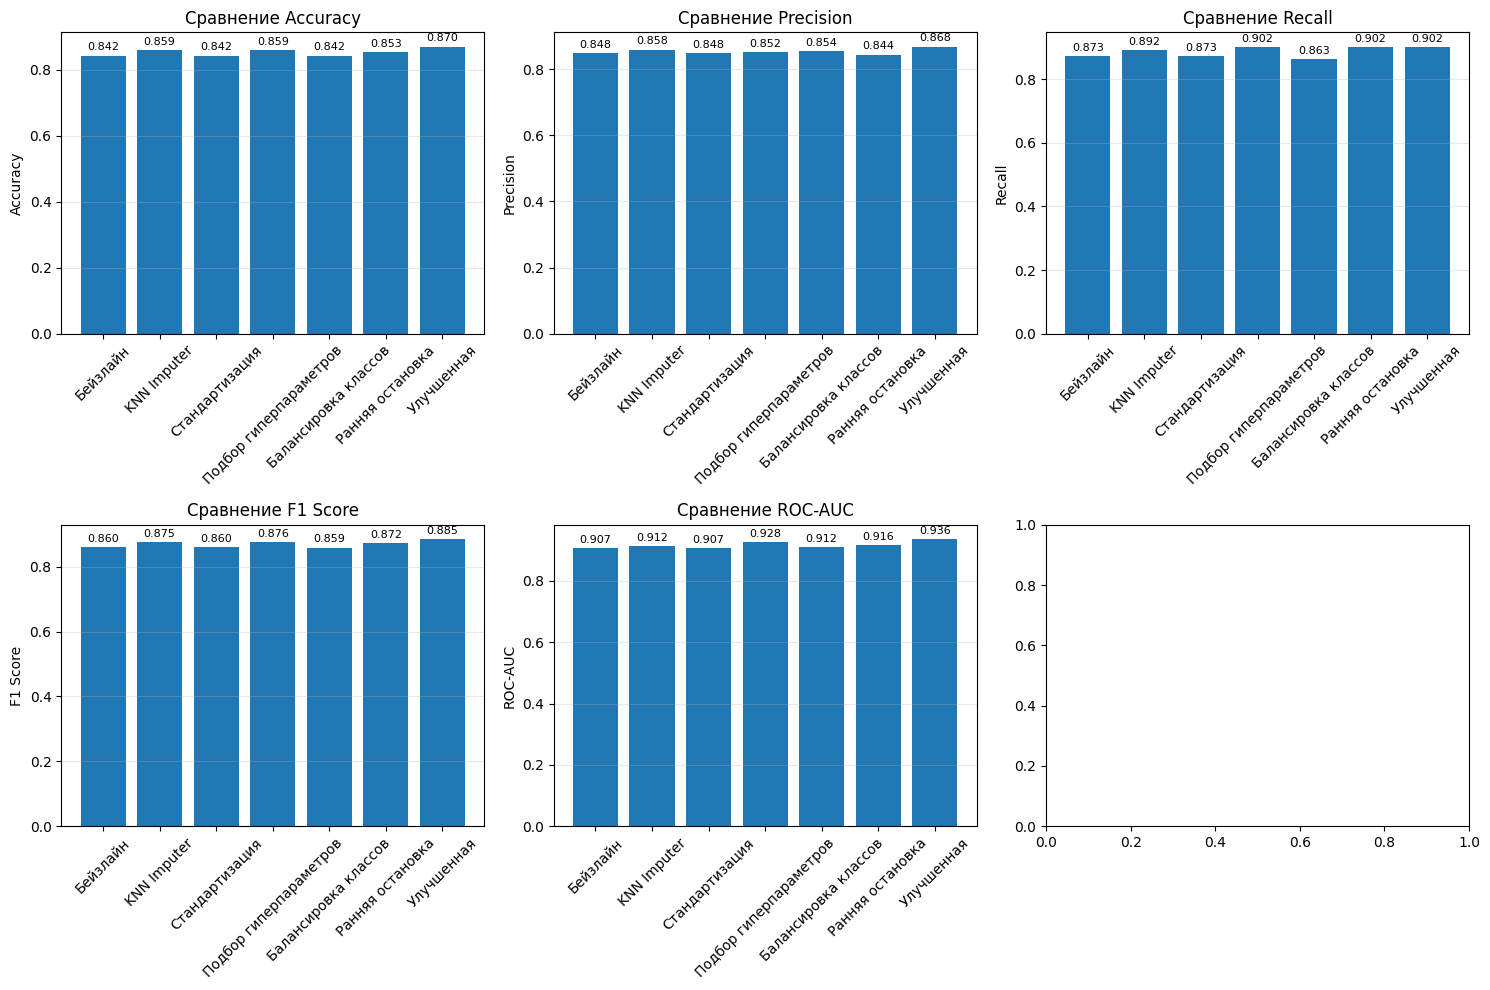

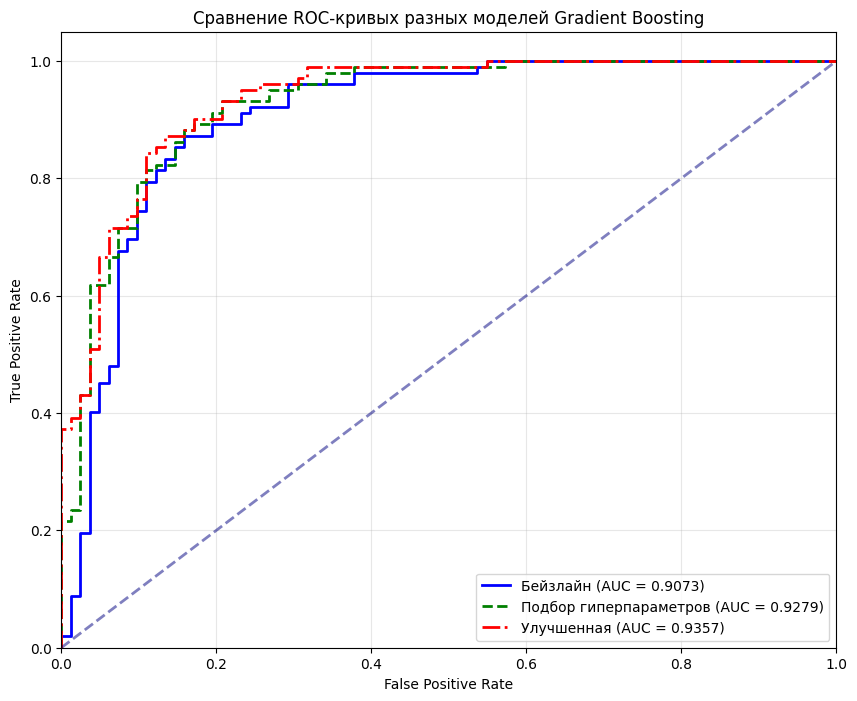

In [18]:
comparison_df = pd.DataFrame({
    'Модель': ['Бейзлайн', 'KNN Imputer', 'Стандартизация', 'Подбор гиперпараметров', 'Балансировка классов', 'Ранняя остановка', 'Улучшенная'],
    'Accuracy': [
        accuracy_score(y_test_c, y_pred_c),
        accuracy_score(y_test_c, y_pred_knn),
        accuracy_score(y_test_c, y_pred_std),
        accuracy_score(y_test_c, y_pred_tuned),
        accuracy_score(y_test_c, y_pred_balanced),
        accuracy_score(y_test_c, y_pred_early),
        accuracy_score(y_test_c, y_pred_improved)
    ],
    'Precision': [
        precision_score(y_test_c, y_pred_c),
        precision_score(y_test_c, y_pred_knn),
        precision_score(y_test_c, y_pred_std),
        precision_score(y_test_c, y_pred_tuned),
        precision_score(y_test_c, y_pred_balanced),
        precision_score(y_test_c, y_pred_early),
        precision_score(y_test_c, y_pred_improved)
    ],
    'Recall': [
        recall_score(y_test_c, y_pred_c),
        recall_score(y_test_c, y_pred_knn),
        recall_score(y_test_c, y_pred_std),
        recall_score(y_test_c, y_pred_tuned),
        recall_score(y_test_c, y_pred_balanced),
        recall_score(y_test_c, y_pred_early),
        recall_score(y_test_c, y_pred_improved)
    ],
    'F1 Score': [
        f1_score(y_test_c, y_pred_c),
        f1_score(y_test_c, y_pred_knn),
        f1_score(y_test_c, y_pred_std),
        f1_score(y_test_c, y_pred_tuned),
        f1_score(y_test_c, y_pred_balanced),
        f1_score(y_test_c, y_pred_early),
        f1_score(y_test_c, y_pred_improved)
    ],
    'ROC-AUC': [
        roc_auc_score(y_test_c, y_pred_proba_c),
        roc_auc_score(y_test_c, gb_pipeline_knn.predict_proba(X_test_c)[:, 1]),
        roc_auc_score(y_test_c, gb_pipeline_std.predict_proba(X_test_c)[:, 1]),
        roc_auc_score(y_test_c, y_pred_proba_tuned),
        roc_auc_score(y_test_c, gb_pipeline_balanced.predict_proba(X_test_c)[:, 1]),
        roc_auc_score(y_test_c, gb_early_pipeline.predict_proba(X_test_c)[:, 1]),
        roc_auc_score(y_test_c, y_pred_proba_improved)
    ]
})

print("\nСравнение моделей Gradient Boosting:")
print(comparison_df.to_string(index=False))

fig, axes = plt.subplots(2, 3, figsize=(15, 10))
metrics = ['Accuracy', 'Precision', 'Recall', 'F1 Score', 'ROC-AUC']

for i, metric in enumerate(metrics):
    row, col = i // 3, i % 3
    axes[row, col].bar(comparison_df['Модель'], comparison_df[metric])
    axes[row, col].set_title(f'Сравнение {metric}')
    axes[row, col].set_ylabel(metric)
    axes[row, col].tick_params(axis='x', rotation=45)
    axes[row, col].grid(axis='y', alpha=0.3)
    
    for j, v in enumerate(comparison_df[metric]):
        axes[row, col].text(j, v + 0.01, f'{v:.3f}', ha='center', va='bottom', fontsize=8)

plt.tight_layout()
plt.show()

plt.figure(figsize=(10, 8))

models = [
    ('Бейзлайн', y_pred_proba_c),
    ('Подбор гиперпараметров', y_pred_proba_tuned),
    ('Улучшенная', y_pred_proba_improved)
]

colors = ['blue', 'green', 'red', 'orange']
linestyles = ['-', '--', '-.', ':']

for (name, y_proba), color, ls in zip(models, colors, linestyles):
    fpr, tpr, _ = roc_curve(y_test_c, y_proba)
    auc = roc_auc_score(y_test_c, y_proba)
    plt.plot(fpr, tpr, color=color, lw=2, linestyle=ls, label=f'{name} (AUC = {auc:.4f})')

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', alpha=0.5)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Сравнение ROC-кривых разных моделей Gradient Boosting')
plt.legend(loc="lower right")
plt.grid(alpha=0.3)
plt.show()

### Исплементируем алгоритм

In [19]:
class SimpleDecisionTree:
    def __init__(self, max_depth=3, min_samples_split=2, min_samples_leaf=1):
        self.max_depth = max_depth
        self.min_samples_split = min_samples_split
        self.min_samples_leaf = min_samples_leaf
        self.tree = None
        
    def _mse(self, y):
        if len(y) == 0:
            return 0
        return np.mean((y - np.mean(y))**2)
    
    def _split(self, X, y, feature_idx, threshold):
        left_mask = X[:, feature_idx] <= threshold
        right_mask = X[:, feature_idx] > threshold
        return X[left_mask], X[right_mask], y[left_mask], y[right_mask]
    
    def _best_split(self, X, y):
        best_mse = float('inf')
        best_feature = None
        best_threshold = None
        
        n_features = X.shape[1]
        
        for feature_idx in range(n_features):
            thresholds = np.unique(X[:, feature_idx])
            
            for threshold in thresholds:
                X_left, X_right, y_left, y_right = self._split(X, y, feature_idx, threshold)
                
                if len(y_left) < self.min_samples_leaf or len(y_right) < self.min_samples_leaf:
                    continue
                
                mse_left = self._mse(y_left)
                mse_right = self._mse(y_right)
                total_mse = (len(y_left) * mse_left + len(y_right) * mse_right) / len(y)
                
                if total_mse < best_mse:
                    best_mse = total_mse
                    best_feature = feature_idx
                    best_threshold = threshold
        
        return best_feature, best_threshold, best_mse
    
    def _build_tree(self, X, y, depth=0):
        n_samples, n_features = X.shape
        
        if (self.max_depth is not None and depth >= self.max_depth or
            n_samples < self.min_samples_split):
            return np.mean(y)
        
        feature, threshold, mse = self._best_split(X, y)
        
        if feature is None:
            return np.mean(y)
        
        X_left, X_right, y_left, y_right = self._split(X, y, feature, threshold)
        
        left_subtree = self._build_tree(X_left, y_left, depth + 1)
        right_subtree = self._build_tree(X_right, y_right, depth + 1)
        
        return {
            'feature': feature,
            'threshold': threshold,
            'left': left_subtree,
            'right': right_subtree,
            'is_leaf': False
        }
    
    def _predict_sample(self, x, node):
        if isinstance(node, dict) and not node.get('is_leaf', False):
            if x[node['feature']] <= node['threshold']:
                return self._predict_sample(x, node['left'])
            else:
                return self._predict_sample(x, node['right'])
        else:
            if isinstance(node, dict):
                return node.get('value', 0)
            return node
    
    def fit(self, X, y):
        self.tree = self._build_tree(X, y)
        return self
    
    def predict(self, X):
        return np.array([self._predict_sample(x, self.tree) for x in X])


class MyGradientBoostingClassifier:
    def __init__(self, n_estimators=100, learning_rate=0.1, max_depth=3,
                 min_samples_split=2, min_samples_leaf=1, subsample=1.0,
                 random_state=None):
        self.n_estimators = n_estimators
        self.learning_rate = learning_rate
        self.max_depth = max_depth
        self.min_samples_split = min_samples_split
        self.min_samples_leaf = min_samples_leaf
        self.subsample = subsample
        self.random_state = random_state
        self.trees = []
        self.initial_prediction = None
        
        if random_state is not None:
            np.random.seed(random_state)
    
    @staticmethod
    def _sigmoid(x):
        return 1 / (1 + np.exp(-x))
    
    @staticmethod
    def _log_loss_gradient(y, p):
        return y - p
    
    def _bootstrap_samples(self, X, y):
        n_samples = X.shape[0]
        
        if self.subsample < 1.0:
            subsample_size = int(self.subsample * n_samples)
            indices = np.random.choice(n_samples, subsample_size, replace=False)
        else:
            indices = np.random.choice(n_samples, n_samples, replace=True)
        
        return X[indices], y[indices]
    
    def fit(self, X, y):
        n_samples = X.shape[0]
        
        pos_class_ratio = np.sum(y == 1) / n_samples
        self.initial_prediction = np.log(pos_class_ratio / (1 - pos_class_ratio + 1e-10))
        
        current_predictions = np.full(n_samples, self.initial_prediction)
        
        for i in range(self.n_estimators):
            probabilities = self._sigmoid(current_predictions)
            
            residuals = self._log_loss_gradient(y, probabilities)
            
            X_bootstrap, residuals_bootstrap = self._bootstrap_samples(X, residuals)
            
            tree = SimpleDecisionTree(
                max_depth=self.max_depth,
                min_samples_split=self.min_samples_split,
                min_samples_leaf=self.min_samples_leaf
            )
            
            tree.fit(X_bootstrap, residuals_bootstrap)
            
            tree_predictions = tree.predict(X)
            
            current_predictions += self.learning_rate * tree_predictions
            
            self.trees.append(tree)
            
            if (i + 1) % 20 == 0:
                temp_proba = self._sigmoid(current_predictions)
                temp_pred = (temp_proba > 0.5).astype(int)
                accuracy = np.mean(temp_pred == y)
                print(f"  Дерево {i+1}/{self.n_estimators}, Accuracy на обучении: {accuracy:.4f}")
        
        return self
    
    def predict_proba(self, X):
        n_samples = X.shape[0]
        predictions = np.full(n_samples, self.initial_prediction)
        
        for tree in self.trees:
            predictions += self.learning_rate * tree.predict(X)
        
        probabilities = self._sigmoid(predictions)
        
        return np.column_stack([1 - probabilities, probabilities])
    
    def predict(self, X):
        probabilities = self.predict_proba(X)[:, 1]
        return (probabilities > 0.5).astype(int)


### Обучим бейзлайн имплементированной модели.

In [20]:
print("\nОбучение имплементированной модели градиентного бустинга...")

numeric_features_indices = [i for i, col in enumerate(X_class.columns) if col in numeric_features]

X_numeric = X_class[numeric_features].copy()

imputer = SimpleImputer(strategy='mean')
X_numeric_imputed = imputer.fit_transform(X_numeric)

scaler = StandardScaler()
X_numeric_scaled = scaler.fit_transform(X_numeric_imputed)

X_train_num, X_test_num, y_train_c, y_test_c = train_test_split(
    X_numeric_scaled, y_class, test_size=0.2, random_state=42, stratify=y_class
)

print(f"Размер тренировочной выборки (только числовые признаки): {X_train_num.shape}")
print(f"Размер тестовой выборки (только числовые признаки): {X_test_num.shape}")

print("\nОбучение имплементированного градиентного бустинга...")
my_gb = MyGradientBoostingClassifier(
    n_estimators=100,
    learning_rate=0.1,
    max_depth=3,
    min_samples_split=10,
    min_samples_leaf=5,
    subsample=0.8,
    random_state=42
)

my_gb.fit(X_train_num, y_train_c.values)

y_pred_my = my_gb.predict(X_test_num)
y_pred_proba_my = my_gb.predict_proba(X_test_num)[:, 1]

print("\nКачество имплементированной модели (Gradient Boosting):")
print(f"Accuracy: {accuracy_score(y_test_c, y_pred_my):.4f}")
print(f"Precision: {precision_score(y_test_c, y_pred_my):.4f}")
print(f"Recall: {recall_score(y_test_c, y_pred_my):.4f}")
print(f"F1 Score: {f1_score(y_test_c, y_pred_my):.4f}")
print(f"ROC-AUC: {roc_auc_score(y_test_c, y_pred_proba_my):.4f}")


Обучение имплементированной модели градиентного бустинга...
Размер тренировочной выборки (только числовые признаки): (736, 6)
Размер тестовой выборки (только числовые признаки): (184, 6)

Обучение имплементированного градиентного бустинга...
  Дерево 20/100, Accuracy на обучении: 0.7921
  Дерево 40/100, Accuracy на обучении: 0.7976
  Дерево 60/100, Accuracy на обучении: 0.8016
  Дерево 80/100, Accuracy на обучении: 0.8111
  Дерево 100/100, Accuracy на обучении: 0.8152

Качество имплементированной модели (Gradient Boosting):
Accuracy: 0.7826
Precision: 0.7768
Recall: 0.8529
F1 Score: 0.8131
ROC-AUC: 0.8555


### Сравним бейзлайн имплементированной модели с `sklearn`.


Сравнение имплементированной модели с бейзлайном (на числовых признаках):
                       Модель  Accuracy  Precision   Recall  F1 Score  ROC-AUC
 Бейзлайн (sklearn, числовые)  0.739130   0.750000 0.794118  0.771429 0.824127
Имплементированная (числовые)  0.782609   0.776786 0.852941  0.813084 0.855452


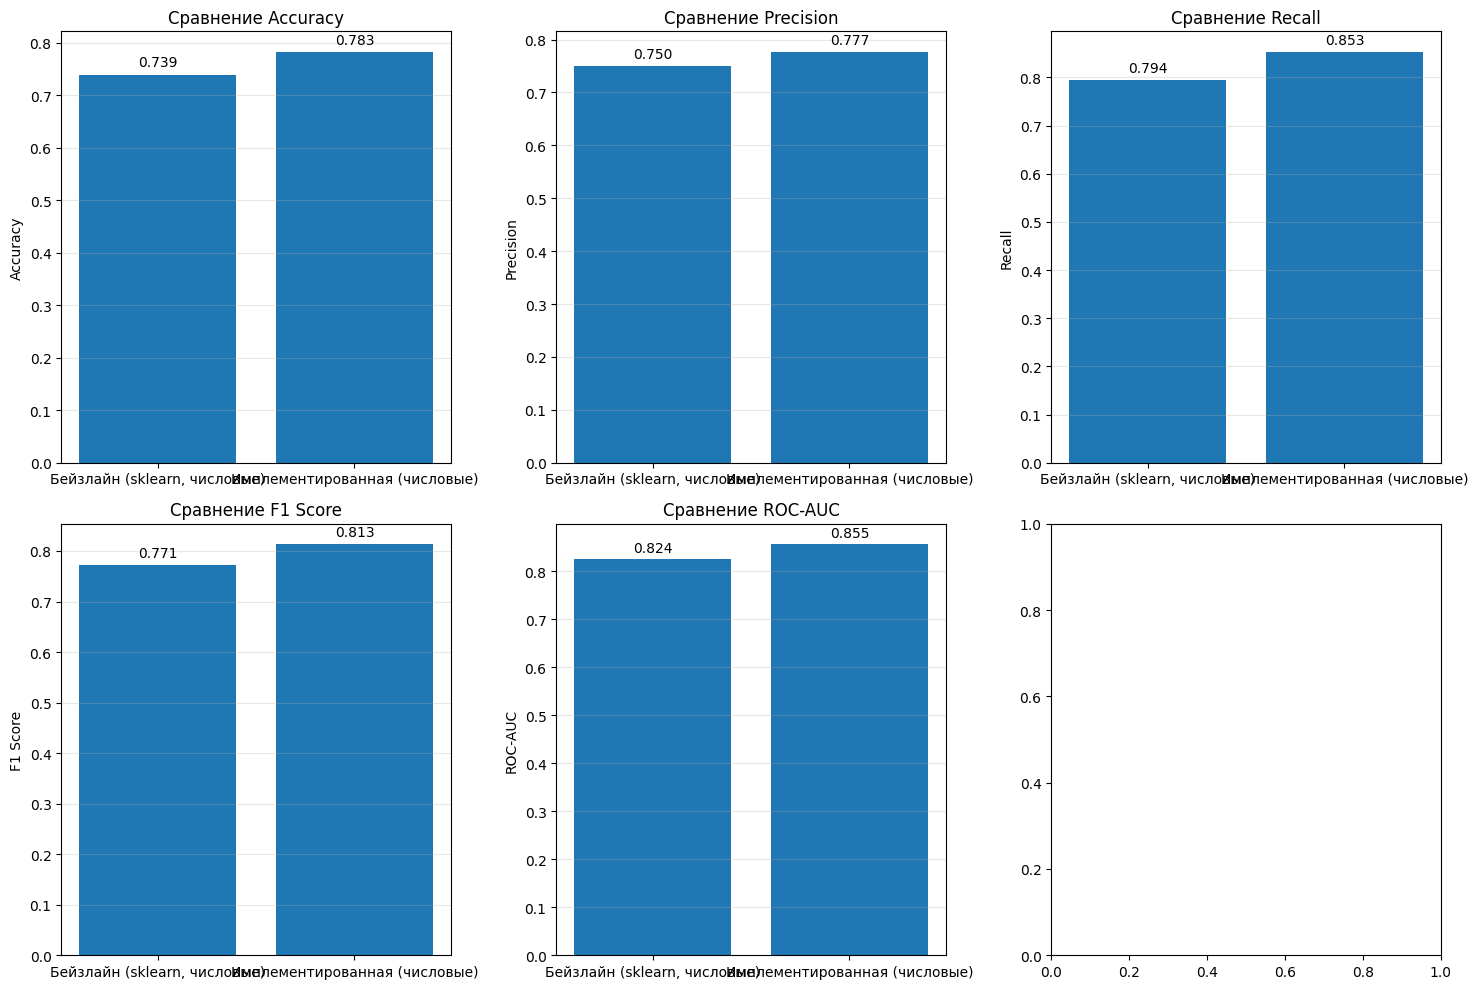

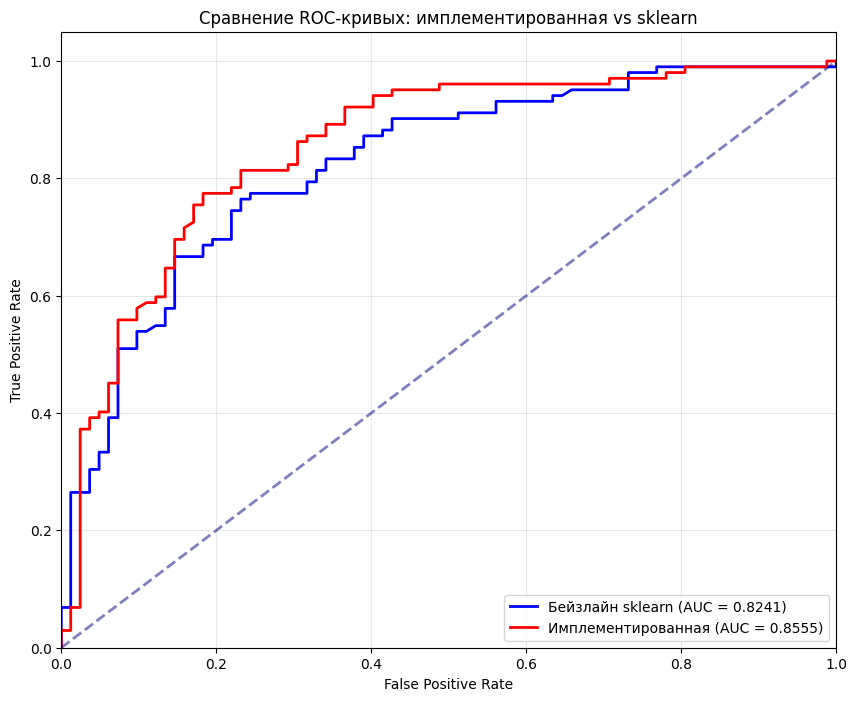

In [21]:
gb_baseline_num = GradientBoostingClassifier(random_state=42)
gb_baseline_num.fit(X_train_num, y_train_c)
y_pred_baseline_num = gb_baseline_num.predict(X_test_num)
y_pred_proba_baseline_num = gb_baseline_num.predict_proba(X_test_num)[:, 1]

comparison_implemented = pd.DataFrame({
    'Модель': ['Бейзлайн (sklearn, числовые)', 'Имплементированная (числовые)'],
    'Accuracy': [
        accuracy_score(y_test_c, y_pred_baseline_num),
        accuracy_score(y_test_c, y_pred_my)
    ],
    'Precision': [
        precision_score(y_test_c, y_pred_baseline_num),
        precision_score(y_test_c, y_pred_my)
    ],
    'Recall': [
        recall_score(y_test_c, y_pred_baseline_num),
        recall_score(y_test_c, y_pred_my)
    ],
    'F1 Score': [
        f1_score(y_test_c, y_pred_baseline_num),
        f1_score(y_test_c, y_pred_my)
    ],
    'ROC-AUC': [
        roc_auc_score(y_test_c, y_pred_proba_baseline_num),
        roc_auc_score(y_test_c, y_pred_proba_my)
    ]
})

print("\nСравнение имплементированной модели с бейзлайном (на числовых признаках):")
print(comparison_implemented.to_string(index=False))

fig, axes = plt.subplots(2, 3, figsize=(15, 10))
metrics = ['Accuracy', 'Precision', 'Recall', 'F1 Score', 'ROC-AUC']

for i, metric in enumerate(metrics):
    row, col = i // 3, i % 3
    axes[row, col].bar(comparison_implemented['Модель'], comparison_implemented[metric])
    axes[row, col].set_title(f'Сравнение {metric}')
    axes[row, col].set_ylabel(metric)
    axes[row, col].grid(axis='y', alpha=0.3)
    
    for j, v in enumerate(comparison_implemented[metric]):
        axes[row, col].text(j, v + 0.01, f'{v:.3f}', ha='center', va='bottom', fontsize=10)

plt.tight_layout()
plt.show()

plt.figure(figsize=(10, 8))

fpr_baseline, tpr_baseline, _ = roc_curve(y_test_c, y_pred_proba_baseline_num)
auc_baseline = roc_auc_score(y_test_c, y_pred_proba_baseline_num)

fpr_my, tpr_my, _ = roc_curve(y_test_c, y_pred_proba_my)
auc_my = roc_auc_score(y_test_c, y_pred_proba_my)

plt.plot(fpr_baseline, tpr_baseline, color='blue', lw=2, label=f'Бейзлайн sklearn (AUC = {auc_baseline:.4f})')
plt.plot(fpr_my, tpr_my, color='red', lw=2, label=f'Имплементированная (AUC = {auc_my:.4f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', alpha=0.5)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Сравнение ROC-кривых: имплементированная vs sklearn')
plt.legend(loc="lower right")
plt.grid(alpha=0.3)
plt.show()

### Попробуем улучшить бейзлайн

In [22]:
X_all = X_class.copy()

label_encoders = {}
for col in categorical_features:
    le = LabelEncoder()
    X_all[col] = X_all[col].fillna(X_all[col].mode()[0] if not X_all[col].mode().empty else 0)
    X_all[col] = le.fit_transform(X_all[col].astype(str))
    label_encoders[col] = le

imputer_all = SimpleImputer(strategy='mean')
X_all_imputed = imputer_all.fit_transform(X_all)

scaler_all = StandardScaler()
X_all_scaled = scaler_all.fit_transform(X_all_imputed)

X_train_all, X_test_all, y_train_c, y_test_c = train_test_split(
    X_all_scaled, y_class, test_size=0.2, random_state=42, stratify=y_class
)

print(f"Размер тренировочной выборки (все признаки): {X_train_all.shape}")
print(f"Размер тестовой выборки (все признаки): {X_test_all.shape}")

print("\nОбучение улучшенной имплементированной модели...")
my_gb_improved = MyGradientBoostingClassifier(
    n_estimators=200,
    learning_rate=0.05,
    max_depth=4,
    min_samples_split=5,
    min_samples_leaf=2,
    subsample=0.8,
    random_state=42
)

my_gb_improved.fit(X_train_all, y_train_c.values)

y_pred_my_improved = my_gb_improved.predict(X_test_all)
y_pred_proba_my_improved = my_gb_improved.predict_proba(X_test_all)[:, 1]

print("\nКачество улучшенной имплементированной модели:")
print(f"Accuracy: {accuracy_score(y_test_c, y_pred_my_improved):.4f}")
print(f"Precision: {precision_score(y_test_c, y_pred_my_improved):.4f}")
print(f"Recall: {recall_score(y_test_c, y_pred_my_improved):.4f}")
print(f"F1 Score: {f1_score(y_test_c, y_pred_my_improved):.4f}")
print(f"ROC-AUC: {roc_auc_score(y_test_c, y_pred_proba_my_improved):.4f}")

Размер тренировочной выборки (все признаки): (736, 13)
Размер тестовой выборки (все признаки): (184, 13)

Обучение улучшенной имплементированной модели...
  Дерево 20/200, Accuracy на обучении: 0.8220
  Дерево 40/200, Accuracy на обучении: 0.8410
  Дерево 60/200, Accuracy на обучении: 0.8533
  Дерево 80/200, Accuracy на обучении: 0.8682
  Дерево 100/200, Accuracy на обучении: 0.8723
  Дерево 120/200, Accuracy на обучении: 0.8764
  Дерево 140/200, Accuracy на обучении: 0.8764
  Дерево 160/200, Accuracy на обучении: 0.8777
  Дерево 180/200, Accuracy на обучении: 0.8818
  Дерево 200/200, Accuracy на обучении: 0.8859

Качество улучшенной имплементированной модели:
Accuracy: 0.8315
Precision: 0.8198
Recall: 0.8922
F1 Score: 0.8545
ROC-AUC: 0.9254


### Сравним с бейзлайном


Итоговое сравнение всех моделей Gradient Boosting:
                                      Модель  Accuracy  Precision   Recall  F1 Score  ROC-AUC
            Бейзлайн (sklearn, все признаки)  0.467391   0.514925 0.676471  0.584746 0.388749
          Улучшенная (sklearn, все признаки)  0.842391   0.847619 0.872549  0.859903 0.905667
           Имплементированная (все признаки)  0.461957   0.511111 0.676471  0.582278 0.384804
Имплементированная улучшенная (все признаки)  0.831522   0.819820 0.892157  0.854460 0.925395


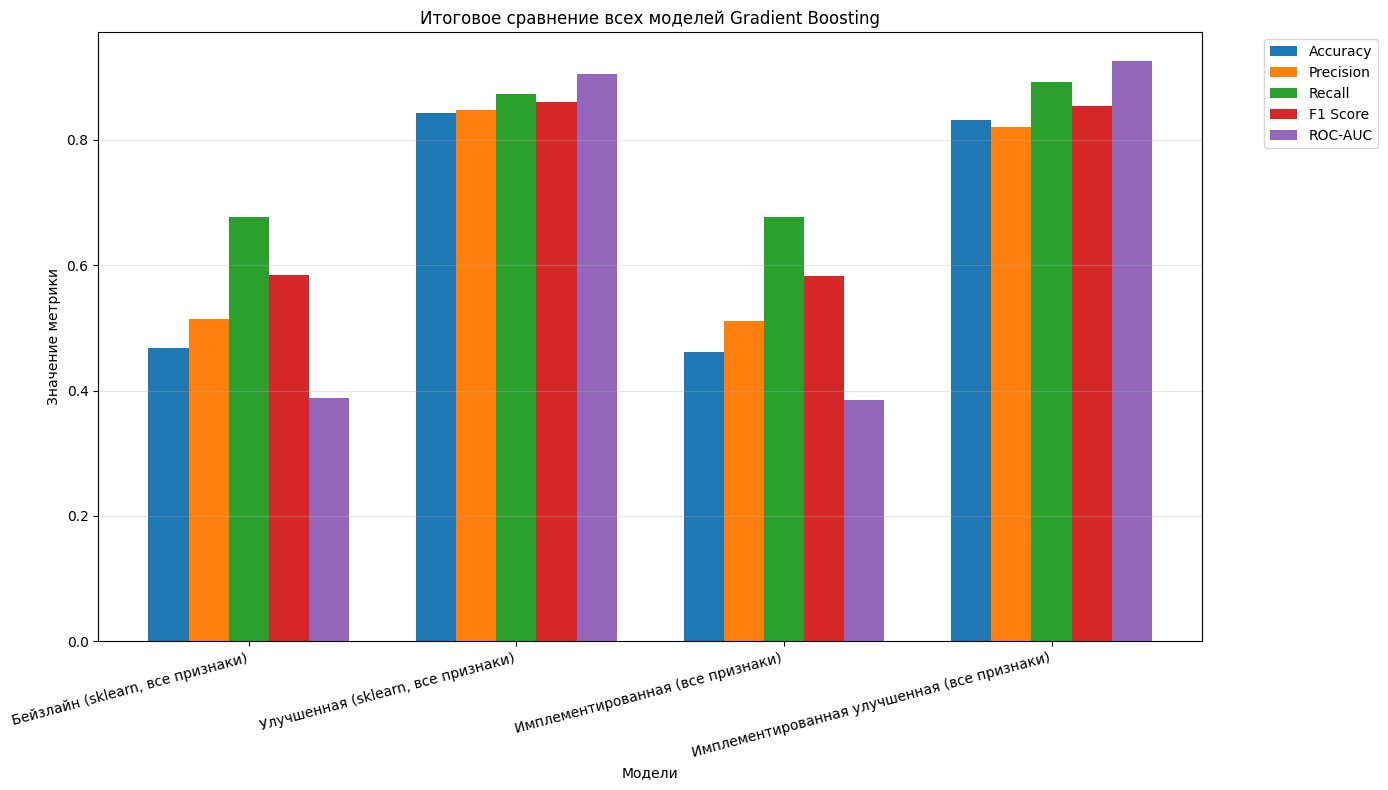

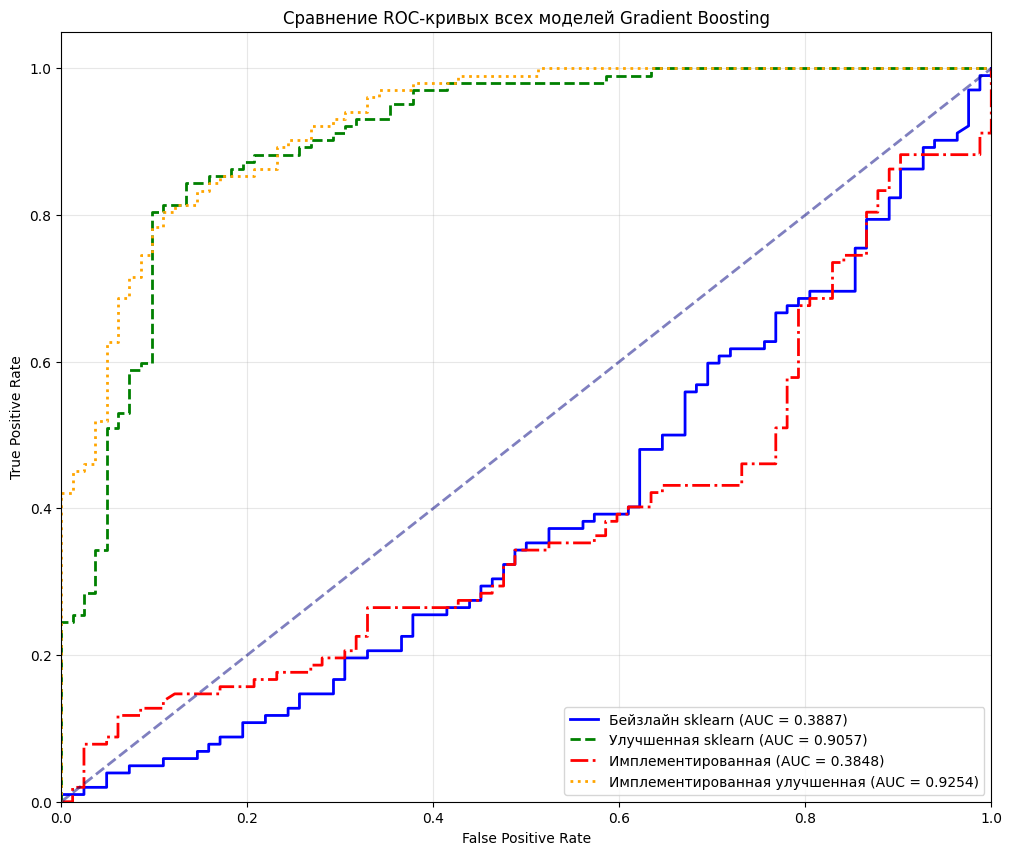

In [23]:
improved_gb_sklearn = GradientBoostingClassifier(
    n_estimators=200,
    learning_rate=0.05,
    max_depth=4,
    min_samples_split=5,
    min_samples_leaf=2,
    subsample=0.8,
    random_state=42
)

improved_gb_sklearn.fit(X_train_all, y_train_c)
y_pred_sklearn_improved = improved_gb_sklearn.predict(X_test_all)
y_pred_proba_sklearn_improved = improved_gb_sklearn.predict_proba(X_test_all)[:, 1]

final_comparison = pd.DataFrame({
    'Модель': [
        'Бейзлайн (sklearn, все признаки)', 
        'Улучшенная (sklearn, все признаки)',
        'Имплементированная (все признаки)',
        'Имплементированная улучшенная (все признаки)'
    ],
    'Accuracy': [
        accuracy_score(y_test_c, gb_baseline_num.predict(X_test_all[:, :len(numeric_features)])),
        accuracy_score(y_test_c, y_pred_sklearn_improved),
        accuracy_score(y_test_c, my_gb.predict(X_test_all[:, :len(numeric_features)])),
        accuracy_score(y_test_c, y_pred_my_improved)
    ],
    'Precision': [
        precision_score(y_test_c, gb_baseline_num.predict(X_test_all[:, :len(numeric_features)])),
        precision_score(y_test_c, y_pred_sklearn_improved),
        precision_score(y_test_c, my_gb.predict(X_test_all[:, :len(numeric_features)])),
        precision_score(y_test_c, y_pred_my_improved)
    ],
    'Recall': [
        recall_score(y_test_c, gb_baseline_num.predict(X_test_all[:, :len(numeric_features)])),
        recall_score(y_test_c, y_pred_sklearn_improved),
        recall_score(y_test_c, my_gb.predict(X_test_all[:, :len(numeric_features)])),
        recall_score(y_test_c, y_pred_my_improved)
    ],
    'F1 Score': [
        f1_score(y_test_c, gb_baseline_num.predict(X_test_all[:, :len(numeric_features)])),
        f1_score(y_test_c, y_pred_sklearn_improved),
        f1_score(y_test_c, my_gb.predict(X_test_all[:, :len(numeric_features)])),
        f1_score(y_test_c, y_pred_my_improved)
    ],
    'ROC-AUC': [
        roc_auc_score(y_test_c, gb_baseline_num.predict_proba(X_test_all[:, :len(numeric_features)])[:, 1]),
        roc_auc_score(y_test_c, y_pred_proba_sklearn_improved),
        roc_auc_score(y_test_c, my_gb.predict_proba(X_test_all[:, :len(numeric_features)])[:, 1]),
        roc_auc_score(y_test_c, y_pred_proba_my_improved)
    ]
})

print("\nИтоговое сравнение всех моделей Gradient Boosting:")
print(final_comparison.to_string(index=False))

fig, ax = plt.subplots(figsize=(14, 8))
x = np.arange(len(final_comparison['Модель']))
width = 0.15

metrics_final = ['Accuracy', 'Precision', 'Recall', 'F1 Score', 'ROC-AUC']
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd']

for i, (metric, color) in enumerate(zip(metrics_final, colors)):
    ax.bar(x + i*width - 2*width, final_comparison[metric], width, label=metric, color=color)

ax.set_xlabel('Модели')
ax.set_ylabel('Значение метрики')
ax.set_title('Итоговое сравнение всех моделей Gradient Boosting')
ax.set_xticks(x)
ax.set_xticklabels(final_comparison['Модель'], rotation=15, ha='right')
ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
ax.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

plt.figure(figsize=(12, 10))

models_roc = [
    ('Бейзлайн sklearn', gb_baseline_num.predict_proba(X_test_all[:, :len(numeric_features)])[:, 1]),
    ('Улучшенная sklearn', y_pred_proba_sklearn_improved),
    ('Имплементированная', my_gb.predict_proba(X_test_all[:, :len(numeric_features)])[:, 1]),
    ('Имплементированная улучшенная', y_pred_proba_my_improved)
]

colors = ['blue', 'green', 'red', 'orange']
linestyles = ['-', '--', '-.', ':']

for (name, y_proba), color, ls in zip(models_roc, colors, linestyles):
    fpr, tpr, _ = roc_curve(y_test_c, y_proba)
    auc = roc_auc_score(y_test_c, y_proba)
    plt.plot(fpr, tpr, color=color, lw=2, linestyle=ls, label=f'{name} (AUC = {auc:.4f})')

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', alpha=0.5)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Сравнение ROC-кривых всех моделей Gradient Boosting')
plt.legend(loc="lower right")
plt.grid(alpha=0.3)
plt.show()

# Выводы

Как видно, примененнем вышеописанных гипотез удалось достичь улучшения показателей бейзлайнов как в случае использования `sklearn`, так и исплементированной модели.